# Superdense Coding

This notebook demonstrates Superdense Coding (SDC) in quantum computing. We first use Qiskit's simulator to test our quantum circuit, and then try it out on a real quantum computer.


## 1. The Difference between Superdense Coding and Quantum Teleportation

Quantum teleportation and superdense coding are closely related and might cause confusion if not properly explained or differentiate. 

Quantum teleportation is a process by which the state of qubit ($|\psi\rangle$) can be transmitted from one location to another, with the help of classical communication and a Bell pair. In other words, we can say it is a protocol that destroys the quantum state of a qubit in one location and recreates it on a qubit at a distant location, with the help of shared entanglement. Superdense coding is a procedure that allows someone to send two classical bits to another party using just a single qubit of communication.

The teleportation protocol is actually a flipped version of the superdense coding protocol, in
the sense that Alice and Bob merely “swap their equipment.”



![image1](images/superdense.png)




## 2. The Process

### 2.1 Step 1
The process starts with a third party, who we'll call (Eve). Two qubits are prepared by Eve in an entangled state. She initially starts the 2 qubits in the basis state $|0\rangle$. She applies Hadamard gate ($H$) to the first qubit to create superposition. She then applies CNOT gate ($CX$) using the first qubit as a control and the second as the target. This is the entangled state (Bell pair) we mention earlier. 

#### Outcome States

Eve first applied Hadamard gate. 

When H gate is applied to first qubit, it enters into superposition and we get the state:
$$|0+\rangle  =  \tfrac{1}{\sqrt{2}}(|00\rangle + |01\rangle)$$

Then Eve applies the CNOT gate. The CNOT gate entangles both qubits, that is, it flips the target if the control is $|1\rangle$. Note that the control is on our first qubit.

$$\text{CNOT} \tfrac{1}{\sqrt{2}}(|00\rangle + |01\rangle) = \tfrac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$$

### 2.2 Step 2

Eve sent the first qubit to Alice and second qubit to Bob. The goal of the protocol is for Alice to send 2 classical bits of information to Bob using her qubit. But before she does, she needs to apply a set of quantum gates to her qubit depending on the 2 bits of information she wants to send


Encoding Rules for Superdense Coding (Alice protocol)
Quantum gates/rules

<!--- Table does not render properly when built to html. This is a problem with nbconvert. Replaced with image
| Intended Message | Applied Gate | Resulting State ($\cdot\sqrt{2}$)|
|:----------------:|:------------:|:--------------------------------:|
|00                |$I$           | $|00\rangle + |11\rangle$        |
|01                |$X$           | $|01\rangle + |10\rangle$        |
|10                |$Z$           | $|00\rangle - |11\rangle$        |
|11                |$ZX$          | $|10\rangle - |01\rangle$        |
--->
![image2](images/superdense_table1.png)


Thus if she wants to send a 00, she does nothing to her qubit (apply the identity ($I$) gate). If she sends a 01, then she applies the $X$ gate. Depending on what she wants to send, she applies the appropriate gate. Alice then sends her qubit to Bob for the final step in the process


### 2.3 Step 3

Bob receives Alice's qubit (first qubit) and uses his qubit to decode Eve's message. Notice that he does not need to have knowledge of the state in order to decode it — he only needs knowledge of the restoration operation.

Bob applies a CNOT gate using the first qubit as control and the second as target. Then he applies a Hadamard gate and finally performs a measurement in both qubits to extract the classical bits encoded in Alice's qubit.

<!--- Table does not render properly when built to html. This is a problem with nbconvert. Replaced with image
| Bob Recieves:             | After CNOT-gate:          | After H-gate:  |
|:-------------------------:|:-------------------------:|:--------------:|
| $|00\rangle + |11\rangle$ | $|00\rangle + |01\rangle$ | $|00\rangle$   |
| $|01\rangle + |10\rangle$ | $|01\rangle + |11\rangle$ | $|01\rangle$   |
| $|00\rangle - |11\rangle$ | $|00\rangle - |10\rangle$ | $|10\rangle$   |
| $|10\rangle - |01\rangle$ | $|11\rangle - |01\rangle$ | $|11\rangle$   |
--->

![image3](images/superdense_table2.png)

When Bob performs the measurements, he ends up with four possible outcomes with probability of 1 each. Note that the last outcome has a negative sign $-|11\rangle$, writing it as $|11\rangle$ is also correct because the probability is calculated as the amplitude of squared.


## 3. Simulating the Superdense Coding Protocol


In [1]:
# Importing all necessary libraries for work.

from qiskit import *
from qiskit.visualization import plot_histogram
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

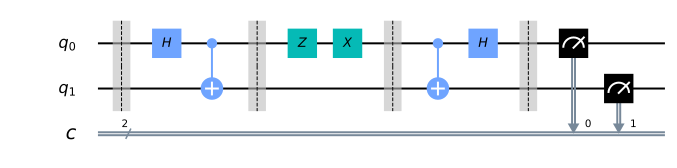

In [2]:
# Create the quantum circuit with 2 qubits and 2 classical bits
qc = QuantumCircuit(2, 2)

qc.barrier()


# First generate the entangled pair between Alice and Bob (Remember: Hadamard followed by CX generates a Bell pair)
# At this point, qubit 1 goes to Bob and qubit 2 goes to Alice
qc.h(0)
qc.cx(0, 1)
qc.barrier()

# Next, Alice encodes her message. First, we need to prepare the state Alice will like to send,
# In this tutorial, Alice is sending 11:

qc.z(0)
qc.x(0)
qc.barrier()

# Alice then sends her qubit to Bob.
# After recieving qubit 0, Bob applies the recovery protocol:
qc.cx(0, 1)
qc.h(0)

# Let's take a measurement to see which classical bit of information Bob receives:
qc.barrier()
qc.measure(0, 0)
qc.measure(1, 1)

# Draw our output
qc.draw(output = "mpl")

### 3.1 Visualizing our measurements

{'11': 1024}


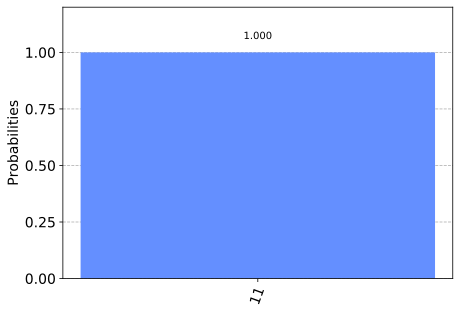

In [3]:
backend = Aer.get_backend('qasm_simulator')
job_sim = execute(qc, backend, shots=1024)
sim_result = job_sim.result()

measurement_result = sim_result.get_counts(qc)
print(measurement_result)
plot_histogram(measurement_result)

## 4. Superdense Coding on a Real Quantum Computer


Let's see how superdense coding works on real quantum computer.

First, we want to load our account to get the least busy quantum system

In [4]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
shots = 256

# Load local account information
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 and not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)
job = execute(qc, backend=backend, shots=shots)


least busy backend:  ibmqx2


In [5]:
# Monitoring our job
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job is being validated

Job Status: job is actively running

Job Status: job has successfully run


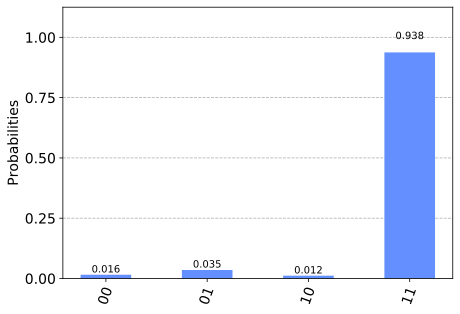

In [6]:
# Plotting our result
result = job.result()
plot_histogram(result.get_counts(qc))

As we see that there are a few results from the other three states when run in a real quantum computer. These are due to errors in the gates that were applied and qubit decoherence.

In [7]:
correct_results = result.get_counts(qc)['11']
accuracy = (correct_results/float(shots))*100
print("Accuracy = %.2f%%" % accuracy)

Accuracy = 93.75%


In [8]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.11.1',
 'qiskit-aer': '0.3.4',
 'qiskit-ignis': '0.2.0',
 'qiskit-ibmq-provider': '0.4.5',
 'qiskit-aqua': '0.6.2',
 'qiskit': '0.14.1'}